## Random sample imputation

- Replace NA by a randomly sampled value from the dataset

- Preserves distribution

### When to use it? 

- Data MCAR


### Pros

- Easy 
- Completes dataset
- Preserves distribution

### Cons

- Randomness
- Distorts covariance 


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/FeatureEngineering/trainh.csv")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [52]:
data.select_dtypes(include=['object'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [53]:
data = data[ ['BsmtQual', 'FireplaceQu', 'GarageType', 'Utilities',	'LotConfig','SalePrice'] ]

In [54]:
data.isnull().mean()

BsmtQual       0.025342
FireplaceQu    0.472603
GarageType     0.055479
Utilities      0.000000
LotConfig      0.000000
SalePrice      0.000000
dtype: float64

In [55]:
data.head()

,BsmtQual,FireplaceQu,GarageType,Utilities,LotConfig,SalePrice
0,Gd,NaN,Attchd,AllPub,Inside,208500
1,Gd,TA,Attchd,AllPub,FR2,181500
2,Gd,TA,Attchd,AllPub,Inside,223500
3,TA,Gd,Detchd,AllPub,Corner,140000
4,Gd,TA,Attchd,AllPub,FR2,250000


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['BsmtQual', 'FireplaceQu', 'GarageType', 'Utilities',	'LotConfig']], data['SalePrice'], test_size=0.2)
X_train.shape, X_test.shape

((1168, 5), (292, 5))

In [57]:
data.columns

Index(['BsmtQual', 'FireplaceQu', 'GarageType', 'Utilities', 'LotConfig',
       'SalePrice'],
      dtype='object')

In [58]:
X_train.columns

Index(['BsmtQual', 'FireplaceQu', 'GarageType', 'Utilities', 'LotConfig'], dtype='object')

In [59]:
X_test.columns

Index(['BsmtQual', 'FireplaceQu', 'GarageType', 'Utilities', 'LotConfig'], dtype='object')

In [60]:
for i in X_train.columns:
  mapper = {k:i for i, k in enumerate(X_train[i].unique(), 0)} 
  mapper[np.nan] = np.nan
  X_train.loc[:, i] = X_train.loc[:, i].map(mapper)
  X_test.loc[:, i] = X_test.loc[:, i].map(mapper)


In [61]:
X_train.isnull().mean()

BsmtQual       0.024829
FireplaceQu    0.480308
GarageType     0.053082
Utilities      0.000000
LotConfig      0.000000
dtype: float64

In [62]:
def impute(df, columns, dft):
    df_temp = df.copy()
    for column in columns:
      df_temp[column] = df_temp[column].apply(lambda x: np.random.choice(dft[column].dropna().values) if pd.isnull(x) else x)
    return df_temp


In [63]:
X_train_0 = impute(X_train, X_train.columns, X_train)
X_test_0 = impute(X_test, X_train.columns, X_train)

In [64]:
X_train_0.isnull().mean()

BsmtQual       0.0
FireplaceQu    0.0
GarageType     0.0
Utilities      0.0
LotConfig      0.0
dtype: float64

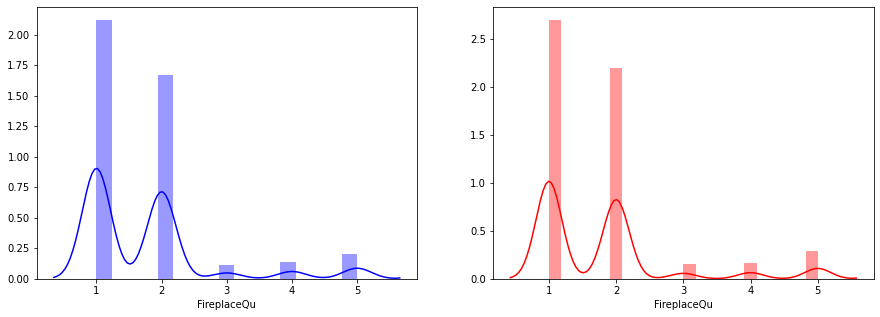

In [65]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(X_train['FireplaceQu'], ax = ax[0], color='blue')
sns.distplot(X_train_0['FireplaceQu'], ax = ax[1], color='red')

In [66]:
from sklearn.impute import SimpleImputer
obj = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent')
X_train_mode = obj.fit_transform(X_train)
X_test_mode = obj.transform(X_test)

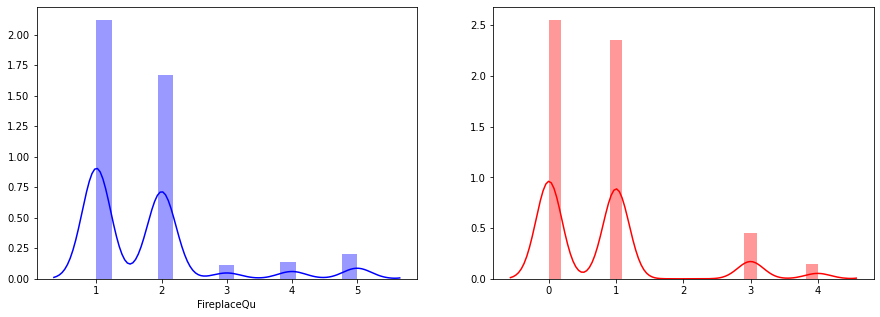

In [67]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.distplot(X_train['FireplaceQu'], ax = ax[0], color='blue')
sns.distplot(X_train_mode[:,0], ax = ax[1], color='red')

In [69]:
print('Std original: ', X_train['FireplaceQu'].std())
print('Std 0: ', X_train_0['FireplaceQu'].std())
print('Std mode: ', X_train_mode[:,0].std())

Std original:  1.009709766713088
Std 0:  1.0257896317162654
Std mode:  0.987127460364766


### Model performance 

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))


4667121135.840314
4310430948.440426


In [72]:
from sklearn.linear_model import RidgeCV
model = RidgeCV()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))



4662405842.035114
4308873511.172552


In [73]:
from sklearn.linear_model import Ridge
model = RidgeCV()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))



4662405842.035114
4308873511.172552


In [74]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))



6352083446.515197
6351520015.90771


In [75]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


38860068959.222725
38877179930.37835


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [76]:
from sklearn.svm import LinearSVR
model = LinearSVR()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))


36107216163.195206
36510297762.12671


In [77]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))


3967220891.135774
3962540271.330078


In [78]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))


4144304018.7141776
4162078405.486228


In [79]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor()
model.fit(X_train_0,y_train)
y_pred = model.predict(X_test_0)
print(mean_squared_error(y_test, y_pred))

model.fit(X_train_mode,y_train)
y_pred = model.predict(X_test_mode)
print(mean_squared_error(y_test, y_pred))



4699429312.53636
4310748392.563153
